In [14]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import SiglipVisionModel, SiglipImageProcessor

sam = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml",
                 "./checkpoints/sam2.1_hiera_large.pt").to(device).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=64, pred_iou_thresh=0.6, stability_score_thresh=0.5,
    mask_threshold=0.5, box_nms_thresh=0.7, crop_n_layers=2,
    crop_overlap_ratio=0.2, min_mask_region_area=300,
    output_mode="binary_mask", multimask_output=True
)

proc   = SiglipImageProcessor.from_pretrained("google/siglip-so400m-patch14-384")
siglip = SiglipVisionModel.from_pretrained("google/siglip-so400m-patch14-384").to(device).eval()

In [15]:
img_path = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png")
save_dir = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo"); save_dir.mkdir(exist_ok=True)
device   = "cuda" if torch.cuda.is_available() else "cpu"
PATCH, GRID, C_DIM = 14, 27, 1152       

In [11]:
bgr  = cv2.imread(str(img_path)); rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
masks = mask_gen.generate(rgb)                   
M = len(masks); print(f"▶ SAM2 mask 수 : {M}")

▶ SAM2 mask 수 : 15


In [16]:
def mask_to_patch_idx(mask_bin: np.ndarray):
    H0, W0 = mask_bin.shape
    s      = 384 / max(H0, W0)
    newH, newW = int(round(H0*s)), int(round(W0*s))
    rs = cv2.resize(mask_bin.astype("uint8"), (newW, newH), cv2.INTER_NEAREST)

    ph, pw = (384-newH)//2, (384-newW)//2
    crop = np.zeros((384,384), np.uint8)
    crop[ph:ph+newH, pw:pw+newW] = rs
    crop = crop[:GRID*PATCH, :GRID*PATCH]        

    grid = crop.reshape(GRID, PATCH, GRID, PATCH).any((1,3))
    return np.flatnonzero(grid)                  

pixel_vals = proc(images=Image.fromarray(rgb), return_tensors="pt")["pixel_values"].to(device)
with torch.no_grad():
    out = siglip(pixel_values=pixel_vals)
hidden = out.last_hidden_state.squeeze(0)        
if hasattr(siglip.vision_model, "post_layernorm"):
    hidden = siglip.vision_model.post_layernorm(hidden)

mask_tokens, mask_arrays = [], []
for i, m in enumerate(masks):
    idx = mask_to_patch_idx(m["segmentation"])
    tok = hidden[idx].mean(0)                    
    tok = torch.nn.functional.normalize(tok, dim=0)
    mask_tokens.append(tok.cpu())
    mask_arrays.append(m["segmentation"].astype("uint8"))
    print(f"  └ mask[{i:02}] patch k={len(idx):3d}")

mask_tokens = torch.stack(mask_tokens)         

torch.save({"img": img_path.name,
            "mask_token": mask_tokens,
            "mask": mask_arrays},
           save_dir / "000_siglip_tokens.pt")
print(f"✓ 저장 : {save_dir/'000_siglip_tokens.pt'}")

  └ mask[00] patch k=  2
  └ mask[01] patch k=  4
  └ mask[02] patch k=  3
  └ mask[03] patch k=  4
  └ mask[04] patch k=  2
  └ mask[05] patch k=  2
  └ mask[06] patch k=  9
  └ mask[07] patch k=  5
  └ mask[08] patch k=  8
  └ mask[09] patch k= 20
  └ mask[10] patch k=475
  └ mask[11] patch k=258
  └ mask[12] patch k= 85
  └ mask[13] patch k= 93
  └ mask[14] patch k=  2
✓ 저장 : /home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/000_siglip_tokens.pt


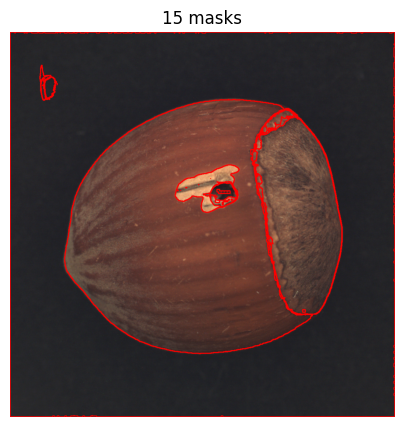

In [17]:
vis = rgb.copy()
for m in mask_arrays:
    cnt,_ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(vis, cnt, -1, (255,0,0), 2)
plt.figure(figsize=(5,5)); plt.axis('off'); plt.title(f"{M} masks")
plt.imshow(vis); plt.show()

# # 구현

In [2]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import SiglipVisionModel, SiglipImageProcessor

IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png")
OUT  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo"); OUT.mkdir(exist_ok=True)
DEV  = "cuda" if torch.cuda.is_available() else "cpu"
PATCH, GRID = 14, 27
MODEL_ID = "google/siglip-so400m-patch14-384"

class SiglipSubsetWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        v = base.vision_model
        e = v.embeddings
        self.patch_proj = getattr(e, "patch_embeddings", None) or e.patch_embedding

        raw_pos = getattr(e, "position_embeddings", None) or e.position_embedding
        pos_tensor = raw_pos.weight if isinstance(raw_pos, torch.nn.Embedding) else raw_pos
        pos_tensor = pos_tensor.squeeze(0) if pos_tensor.dim() == 3 else pos_tensor
        self.register_buffer("pos_full", pos_tensor, persistent=False)  

        self.blocks  = v.encoder.layers
        self.ln_post = v.post_layernorm

    def forward(self, pixel_values: torch.Tensor, patch_idx: np.ndarray):
        idx = torch.as_tensor(patch_idx, device=pixel_values.device, dtype=torch.long)
        x   = self.patch_proj(pixel_values).flatten(2).transpose(1,2)     
        x   = x.index_select(1, idx) + self.pos_full.index_select(0, idx) 

        for blk in self.blocks:
            x = blk(x, attention_mask=None)[0]   
        return self.ln_post(x).squeeze(0)        

In [3]:
sam = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml",
                 "./checkpoints/sam2.1_hiera_large.pt").to(DEV).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=64, pred_iou_thresh=0.6, stability_score_thresh=0.5,
    mask_threshold=0.5, box_nms_thresh=0.7, crop_n_layers=2,
    crop_overlap_ratio=0.2, min_mask_region_area=300,
    output_mode="binary_mask", multimask_output=True
)

proc  = SiglipImageProcessor.from_pretrained(MODEL_ID)
base  = SiglipVisionModel.from_pretrained(MODEL_ID).to(DEV).eval()
subset= SiglipSubsetWrapper(base).to(DEV).eval()

In [4]:
rgb = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
masks = mask_gen.generate(rgb)
print("mask 수 :", len(masks))

mask 수 : 15


In [5]:
pix = proc(images=Image.fromarray(rgb), return_tensors="pt")["pixel_values"].to(DEV)

def mask_to_idx(mask_bin: np.ndarray) -> np.ndarray:
    H,W = mask_bin.shape
    s   = 384 / max(H, W)
    h,w = int(round(H*s)), int(round(W*s))
    rs  = cv2.resize(mask_bin.astype("uint8"), (w,h), cv2.INTER_NEAREST)
    ph,pw = (384-h)//2, (384-w)//2
    canvas = np.zeros((384,384), np.uint8); canvas[ph:ph+h,pw:pw+w] = rs
    canvas = canvas[:GRID*PATCH, :GRID*PATCH]
    grid = canvas.reshape(GRID,PATCH,GRID,PATCH).any((1,3))
    return np.flatnonzero(grid)

tok, arr = [], []
for i,m in enumerate(masks):
    idx = mask_to_idx(m["segmentation"])
    hid = subset(pix, idx)                      
    tok.append(torch.nn.functional.normalize(hid.mean(0), dim=0).cpu())
    arr.append(m["segmentation"].astype("uint8"))
    print(f"mask[{i:02}]  k={len(idx)}")

torch.save({"img_name": IMG.name,
            "mask_token": torch.stack(tok), "mask": arr},
           OUT/"000_siglip_tokens.pt")
print("저장 완료 :", OUT/"000_siglip_tokens.pt")

mask[00]  k=2
mask[01]  k=4
mask[02]  k=3
mask[03]  k=4
mask[04]  k=2
mask[05]  k=2
mask[06]  k=9
mask[07]  k=5
mask[08]  k=8
mask[09]  k=20
mask[10]  k=475
mask[11]  k=258
mask[12]  k=85
mask[13]  k=93
mask[14]  k=2
저장 완료 : /home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/000_siglip_tokens.pt


# # Hazelnut(hole) Token

In [1]:
import torch, cv2, numpy as np, inspect
from PIL import Image
from pathlib import Path
from tqdm import tqdm                               
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import SiglipVisionModel, SiglipImageProcessor

ROOT_IMG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole")
SAVE_DIR = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEV      = "cuda" if torch.cuda.is_available() else "cpu"
PATCH, GRID = 14, 27
MODEL_ID = "google/siglip-so400m-patch14-384"

class SiglipSubsetWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        v, e = base.vision_model, base.vision_model.embeddings
        self.patch_proj = getattr(e, "patch_embeddings", None) or e.patch_embedding

        raw_pos = getattr(e, "position_embeddings", None) or e.position_embedding
        pos = raw_pos.weight if isinstance(raw_pos, torch.nn.Embedding) else raw_pos
        pos = pos.squeeze(0) if pos.dim() == 3 else pos         
        self.register_buffer("pos_full", pos, persistent=False)

        self.blocks  = v.encoder.layers
        self.ln_post = v.post_layernorm
        self.need_mask = "attention_mask" in inspect.signature(self.blocks[0].forward).parameters

    def forward(self, pix: torch.Tensor, patch_idx: np.ndarray):
        idx = torch.as_tensor(patch_idx, device=pix.device, dtype=torch.long)
        x = self.patch_proj(pix).flatten(2).transpose(1,2)           
        x = x.index_select(1, idx) + self.pos_full.index_select(0, idx)   
        for blk in self.blocks:
            x = blk(x, attention_mask=None)[0] if self.need_mask else blk(x)[0]
        return self.ln_post(x).squeeze(0)                            

In [2]:
sam = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml",
                 "./checkpoints/sam2.1_hiera_large.pt").to(DEV).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=64, pred_iou_thresh=0.6, stability_score_thresh=0.5,
    mask_threshold=0.5, box_nms_thresh=0.7, crop_n_layers=2,
    crop_overlap_ratio=0.2, min_mask_region_area=300,
    output_mode="binary_mask", multimask_output=True
)

proc  = SiglipImageProcessor.from_pretrained(MODEL_ID)
base  = SiglipVisionModel.from_pretrained(MODEL_ID).to(DEV).eval()
subset= SiglipSubsetWrapper(base).to(DEV).eval()

In [ ]:
def mask_to_idx(mask_bin: np.ndarray) -> np.ndarray:
    H,W = mask_bin.shape; s = 384 / max(H,W)
    h,w = int(round(H*s)), int(round(W*s))
    rs  = cv2.resize(mask_bin.astype("uint8"), (w,h), cv2.INTER_NEAREST)
    ph,pw = (384-h)//2, (384-w)//2
    canvas = np.zeros((384,384), np.uint8); canvas[ph:ph+h, pw:pw+w] = rs
    grid = canvas[:GRID*PATCH,:GRID*PATCH].reshape(GRID,PATCH,GRID,PATCH).any((1,3))
    return np.flatnonzero(grid)

img_paths = sorted(ROOT_IMG.glob("*.png"))
for img_path in tqdm(img_paths, desc="hazelnut / hole", unit="img"):
    rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    masks = mask_gen.generate(rgb)
    pix   = proc(images=Image.fromarray(rgb), return_tensors="pt")["pixel_values"].to(DEV)

    tok, arr = [], []
    for m in masks:
        idx  = mask_to_idx(m["segmentation"])
        hid  = subset(pix, idx)
        tok.append(torch.nn.functional.normalize(hid.mean(0), dim=0).cpu())
        arr.append(m["segmentation"].astype("uint8"))

    torch.save({"img_name": img_path.name,
                "mask_token": torch.stack(tok),
                "mask": arr},
               SAVE_DIR / f"{img_path.stem}_siglip_tokens.pt")